# Scale Free Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A graph of 3 nodes:
0:[1]
1:[0]
2:[]

Nodes: [0, 1, 2]
Edges: [(0, 1)]


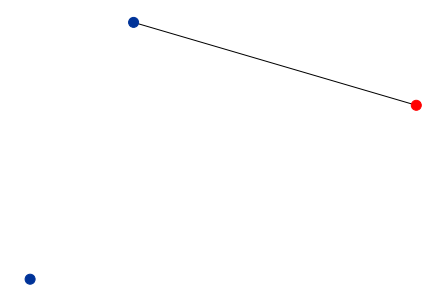

In [3]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.values = {}    #0 for healthy, 1 for infected
        
    def add_node(self, node, val=0):
        """If node is not in a dictionary, add it."""
        if node not in self.gdict:
            self.gdict[node] = []
        self.values[node] = val
    
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
        #Add node2 as a connection for node1, and the other way around
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return #This edge doesn't exist, done
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
            
    def get_nodes(self):
        """Returns a list of nodes."""
        return list(self.gdict.keys())
    
    def get_edges(self):
        """Returns a list of edges."""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
            
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1,0,0)
        BLUE = (0,0.2,0.6)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.values[nodes[i]]==0:
                colors.append(BLUE)
            else:
                colors.append(RED)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
        #nx.draw_spring(g_nx, node_size=100, node_color=colors)
    
#Test Graph
g = Graph()
g.add_edge(0,1)
g.add_edge(0,2)
g.delete_edge(0,2)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.values[0] = 1
g.plot()

In [4]:
def degrees(g):
    """Calculates and plots the degrees distribution for a graph."""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    #print(degrees)
    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    #print(hist)

    plt.plot(hist,'.-');
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    
    return hist

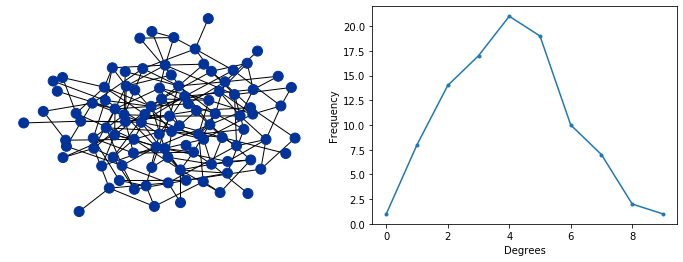

In [5]:
def random_network(n_nodes=7):
    """Creates a random (Erdos type II) network, with N(E)=N(V)."""
    n_edges = 2*n_nodes

    g = Graph()
    for i in range(n_nodes):
        g.add_node(i)
    edges = []
    while len(edges)<n_edges:
        n1 = np.random.randint(low=0, high=n_nodes)
        n2 = np.random.randint(low=0, high=n_nodes)
        if n2<n1:
            n1,n2 = n2,n1

        if (n1,n2) not in edges and n1!=n2:
            g.add_edge(n1,n2)
            edges.append((n1,n2))
    return g
    
#print(g)

g = random_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees_random = degrees(g)

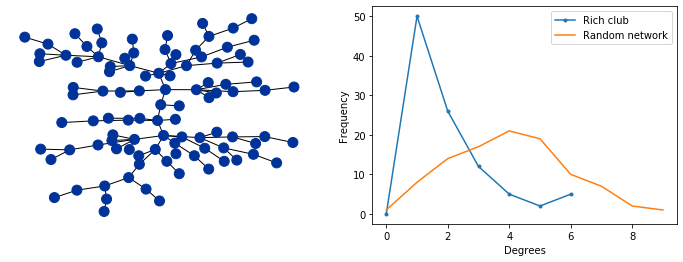

In [6]:
def rich_club_network(n_nodes=7):
    """Alternative network creator"""
    g = Graph()
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        else:
            g.add_edge(i, np.random.randint(low=0, high=i))
    return g

g = rich_club_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g)
plt.plot(degrees_random);
plt.legend(['Rich club','Random network']);

We need to sample different nodes with different probabilities. Fortunately numpy has a function numpy.random.choice that should help.

Still, we have 2 options:

* We can explicitly provide a list of probabilities for each node
* We can keep a list in which every node is presented several times, namely, the same number of times as the number of connections it has. (If you want A to happen with twice probability of B, you can sample from (A, A, B)).

Let's follow the first approach. We'll keep track of the degree of each node, and we'll update it, and we'll also keep track of the total sum of all degrees. Then P(connecting to node i) = degree_i / sum(all degrees)

In [7]:
#Testground for numpy.random.choice(a, size=None, replace=True, p=None)
#One option: sampling from a list with some values overrepresented
a = [1,2,2,2,2,2,2,3]
for i in range(20):
    print(np.random.choice(a), end=' ')

2 2 1 2 2 3 2 2 2 2 2 2 2 2 2 2 3 2 1 2 

In [8]:
#Option 2: sampling with different probabilities (and no replication)
a = [1,2,3]
for i in range(10):
    print(np.random.choice(a, size=2, replace=False, p=[0.6, 0.3, 0.1]))

[2 1]
[1 2]
[2 3]
[2 1]
[1 2]
[2 1]
[1 2]
[2 1]
[2 1]
[2 1]


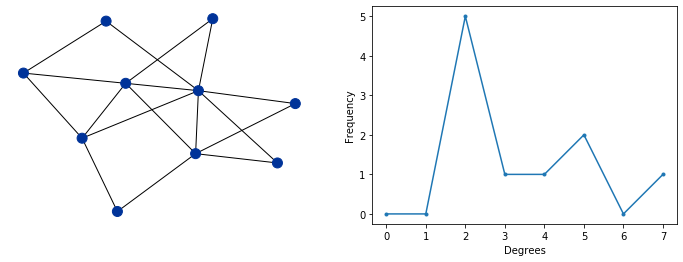

In [9]:
def barabasi(n_nodes=7):
    """Barabasi-Alberts network creator. N_edges ~ 2*N_nodes."""
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        elif i==1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else: #Actual preferential attachment
            connections = np.random.choice(nodes[:i], size=2, replace=False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
        #print(i,'Nodes:',nodes,'Degrees:',degrees)
    return g

g = barabasi(10)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g);


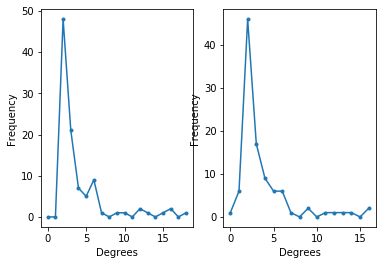

In [10]:
def remove_hub(g):
    """Isolate the most connected node."""
    highest_so_far = 0
    best_node = None
    for node,links in g.gdict.items():
        if len(links)>highest_so_far:
            highest_so_far = len(links)
            best_node = node
    #print(best_node, g.gdict[best_node])
    for node in g.gdict[best_node].copy():
        g.delete_edge(best_node, node)

#Test Graph
g = barabasi(100)
plt.subplot(121);
degrees(g);
remove_hub(g)
plt.subplot(122);
degrees(g);

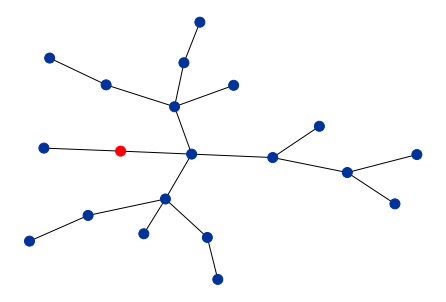

In [11]:
def pandemic(g, prob=0.5, nsteps=10):
    """Runs the pandemic for several steps."""
    nodes = g.get_nodes()
    for node in nodes:
        g.values[node] = 0      #First set all nodes to healthy 
    patient_zero = np.random.randint(low=0, high=len(nodes))
    g.values[patient_zero] = 1  #Only one node is sick, this is a random node
    
    #Infectivity variable
    infectivity_time = #Add in constant infectivity time limit for all nodes 
    
    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        for node in nodes:
            if g.values[node]==1:
                neighbors = g.gdict[node]
                for neighbor in neighbors:
                    if g.values[neighbor]==0 and np.random.uniform()<prob:
                        newly_infected.append(neighbor)
        for node in newly_infected:
            g.values[node] = 1
        history[t] = len(newly_infected)
    return history

#Test Graph
g = rich_club_network(20)
history = pandemic(g, prob=0.1, nsteps=3)
g.plot()

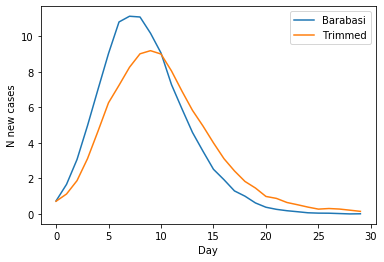

In [12]:
#Computational experiment
N_STEPS = 30
N_TRIALS = 500
PROB = 0.2      #Propagation probability

history = np.zeros(shape=(N_STEPS, N_TRIALS*2))
for i in range(N_TRIALS):
    g = barabasi(100)
    history[:,i] = pandemic(g, prob=PROB, nsteps=N_STEPS)
    remove_hub(g)
    history[:,i+N_TRIALS] = pandemic(g, prob=PROB, nsteps=N_STEPS)
    
plt.plot(np.mean(history[:,:N_TRIALS],axis=1), label='Barabasi');
plt.plot(np.mean(history[:,N_TRIALS:],axis=1), label='Trimmed');   
plt.xlabel('Day');
plt.ylabel('N new cases');
plt.legend(loc='upper right');